In [158]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [159]:
class Value:
  def __init__(self, data, _children = (), _op = '', label = ''):
    self.data = data
    self._prev = set(_children)
    self._op = _op
    self.label = label
    self.grad = 0.0
    self._backward = lambda: None

  # This is a wrapper function for printing and showing the Value Class structure
  def __repr__(self):
    return f"Value(data = {self.data})"

  def __add__(self, other):
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), "+")
    out._backward = _backward
    return out

  def __sub__(self, other):
    return self + (-other)

  def __neg__(self):
    return self * -1

  def __mul__(self, other):
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), "*")
    out._backward = _backward
    return out

    return out

  def __rmul__(self, other):
    return self * other

  def __radd__(self, other):
    return self + other

  def __truediv__(self, other):
    return self * (other**-1)

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self, ), f"**{other}")
    def _backward():
      self.grad += other * (self.data**(other - 1)) * out.grad
    out._backward = _backward
    return out

  def tanh(self):
    def _backward():
      self.grad += (1 - t**2) * out.grad
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), "tanh")
    out._backward = _backward
    return out

  def backward(self):
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    topo = []
    visited = set()
    build_topo(self)
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

  def exp(self):
    def _backward():
      self.grad += out.data * out.grad
    x = self.data
    out = Value(math.exp(x), (self, ), "exp")
    out._backward = _backward
    return out

In [160]:
from graphviz import Digraph

def trace(root):
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges


def draw_dot(root):
  dot = Digraph(format = 'svg', graph_attr={'rankdir':'LR'})
  nodes, edges = trace(root)

  for n in nodes:
    uid = str(id(n))
    # For any value in the graph, create a rectangular {'record'} node for it
    dot.node(name = uid, label = "{%s | data = %.4f| grad = %.4f}" % (n.label, n.data, n.grad), shape = 'record')
    if n._op:
      # If this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      #  And connect tghis node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # Connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [161]:
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
b = Value(6.8813735870195432, label = 'b')

x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'

n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'

In [162]:
o.backward()

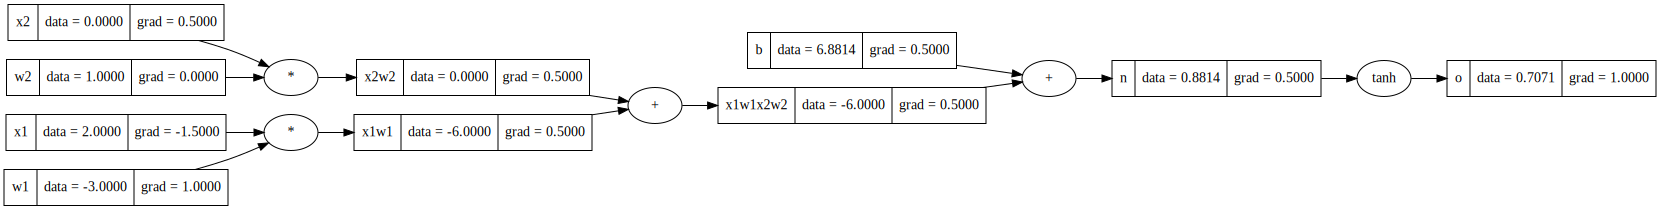

In [163]:
draw_dot(o)

In [164]:
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
b = Value(6.8813735870195432, label = 'b')

x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'

n = x1w1x2w2 + b; n.label = 'n'
#
e = (2*n).exp()
o = (e - 1) / (e + 1)
#
o.label = 'o'
o.backward()
# draw_dot(o)

In [165]:
import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

# print()
# print('x2 = ', x2.grad.item())
# print('w2 = ', w2.grad.item())
# print('x1 = ', x1.grad.item())
# print('w1 = ', w1.grad.item())

0.7071066904050358


In [166]:
class Neuron:
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1, 1))

  def __call__(self, x):
    act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for  n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    params = []
    for neuron in self.neurons:
      ps = neuron.parameters()
      params.extend(ps)
    return params

class MLP:
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    params = []
    for layer in self.layers:
      ps = layer.parameters()
      params.extend(ps)
    return params

In [170]:
xs =[
     [2.0,3.0,-1.0],
     [3.0,-1.0,0.5],
     [0.5,1.0,1.0],
     [1.0,1.0,-1.0]
]

ys = [1.0,-1.0,-1.0,1.0]

x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])

In [171]:
ypred = [n(x) for x in xs]
ypred

[Value(data = 0.9287985232595329),
 Value(data = 0.006570729982804604),
 Value(data = 0.8427788164648328),
 Value(data = 0.5159399664529335)]

In [172]:
#  Mean Squared Error
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss.backward()
loss

Value(data = 4.648402167237256)

In [173]:
for p in n.parameters():
  p.data += -0.15 * p.grad

In [182]:
for k in range(25):
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backward pass
  for p in n.parameters():
    p.grad = 0.0

  loss.backward()

  # update
  for p in n.parameters():
    p.data -= 0.05 * p.grad
  print(k, loss.data)

0 0.005085611424578265
1 0.005029331327618616
2 0.004974238870404445
3 0.004920297333594214
4 0.00486747148583316
5 0.00481572750946292
6 0.004765032930624181
7 0.004715356553453128
8 0.004666668398095734
9 0.004618939642283808
10 0.004572142566237561
11 0.004526250500675657
12 0.004481237777731211
13 0.004437079684585999
14 0.004393752419649469
15 0.0043512330511213775
16 0.004309499477788522
17 0.004268530391916588
18 0.004228305244107886
19 0.004188804210004918
20 0.004150008158727729
21 0.0041118986229410695
22 0.004074457770454033
23 0.004037668377261774
24 0.004001513801944578


In [183]:
ypred

[Value(data = 0.980219824418177),
 Value(data = -0.9863843642736613),
 Value(data = -0.9584421444678815),
 Value(data = 0.9587954181766634)]